### Tech Exellence Advanced Data Science - Generative AI Video Classification Project

##### Project Authors: Tim Tieng, Afia Owusu-Forfie

**Objective**: Develop a model to classify video content into categories such as sports, news, movies, etc., and enhance this classification by generating descriptive captions or summaries that provide additional context about the content. This can be particularly useful for content curation platforms, accessibility applications (e.g., providing descriptions for the hearing impaired), or educational tools where supplementary information enhances learning.

**Data**: Public Dataset: Use a dataset like the YouTube-8M, which has a vast collection of labeled video data suitable for training video classification models.

In [126]:
#%pip install chardet
# %pip install utils

  Using cached utils-1.0.2.tar.gz (13 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13934 sha256=a91c07678fb4cf0e5f568b7d7dc27c73dbc185e3c35fa95da7bd161f4abe33d4
  Stored in directory: c:\users\timot\appdata\local\pip\cache\wheels\b8\39\f5\9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
Note: you may need to restart the kernel to use updated packages.


In [127]:
# Import Packages for project

# Standard Libraries
import csv
import numpy as np
import os
import pandas as pd
import utils

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms, Modeling and Data Pre-processing
import feature_engine
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from scipy.stats import anderson, chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score, roc_auc_score,recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deep Learning
import keras
from keras import layers
from keras.layers import RandomFlip, RandomRotation, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Optimization and Hyperparameter Tuning
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, tpe, hp
import mlflow

import tensorboard

In [119]:
# Obtain the data - Due to issues with larger dataset, the project group is using the dataset provided via kaggle competition that used youtube-8M data
# Create variables that hold the filepath destination to train and validate TFrecord files
frame_level_record1 = "../data/frame-sample/frame/train00.tfrecord"
frame_level_record2 = "../data/frame-sample/frame/train01.tfrecord"
validation_level_record1 = "../data/validate-sample/validate/validate00.tfrecord"
validation_level_record2 = "../data/validate-sample/validate/validate01.tfrecord"

# new data
frame_train1 = "../data/train0255.tfrecord"

print(f"Frame Directory TFrecords Present: {os.listdir('../data/frame-sample/frame')}")
print(f"Validation Directory TFrecords Present: {os.listdir('../data/validate-sample/validate')}")



Frame Directory TFrecords Present: ['train00.tfrecord', 'train01.tfrecord']
Validation Directory TFrecords Present: ['validate00.tfrecord', 'validate01.tfrecord']


In [120]:
# Read in TFRecord files IAW Tensorflow documentation - https://www.tensorflow.org/tutorials/load_data/tfrecord
filenames = [frame_train1]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [121]:
for raw_record in raw_dataset.take(5):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n!\n\x0e\n\x02id\x12\x08\n\x06\n\x047keh\n\x0f\n\x06labels\x12\x05\x1a\x03\n\x01\x00\x12\xde\xbf\x0f\n\xaa\xd7\r\n\x03rgb\x12\xa1\xd7\r\n\x86\x08\n\x83\x08\n\x80\x08\x00\xbe2FLQ\x9c&\x96y\x8f\xb1\xc6z\x9d[\x91mC\x1d\xd8\x84x[8\x8f#h\x82\x94\xbf\x93\x00\xa4\xb1]\xce|\x95\x8f\x88\xd8Y\xf4\xea\xa3Dv\x8a\xa6fP8\x8bH\xa4\xa6:I|=\xd8)\xba\xb3\xe0\xb4j`z5B~\xceMO\xab\x89\x1b\x9ef \xb6q\x8c\xa6L\xa4\xd9\xc9k\x9e~\x90\x9fi;\xa8{Ch\x00\xb3\x9e\xa6\x82|8\x8bU\x95Bvu\xad\xdb0yf\xd9\xde"x\xb1\x91\xcfp\xad\xa1\x80s\xbf\x1b\x84\xb8\xa1\x9e\x00x\x96\xa1\x9fC\x86J\xb4\x92\x8bsJP\x89lBFd\x88S\x91]E\xa1\xa9\xa4Cl{\xa8\'\x8aS_\xba\xa7\xb40\\\xff{\xc1tj4\x95\xa0\xff\xadDFhgR\x95a\'7\xf25r\xc9l|\x9dkj\x8dja\xcef-\xae\xa8\xce\x1d\xdcF\x8dVz\x91o\xc4\xa4I\x95!\x9ca\xa0\xdf\xab\x91\xbbw\x80P\xb9DEE\xd8\xa0\xd2\xe0s8\xb1}r\x88\xffR\x8d8\x9f\x9f\x8b\x82\x91\x91\x94\xb4\xf0;\xad{\x93A&]\x8e\x85\xe6\x9f\x84\xff"GF\xb7\xa1~<g\xa4c\x9a\xeb\x97K\xd8\xc8;\x7f\x00\xeb\x96\xa

In [77]:
# Print out the records in the raw_dataset object to view its original contents
for raw_record in raw_dataset.take(5):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)


features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 82
        value: 103
        value: 346
        value: 350
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "op00"
      }
    }
  }
}

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 261
        value: 1348
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "O900"
      }
    }
  }
}

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 15
        value: 18
        value: 67
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "Oq00"
      }
    }
  }
}

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 0
        value: 1
        value: 1768
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "Li00"
      }
    }
  }
}

features {
  featu

In [122]:
result = {}
# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
  # The values are the Feature objects which contain a `kind` which contains:
  # one of three fields: bytes_list, float_list, int64_list

  kind = feature.WhichOneof('kind')
  result[key] = np.array(getattr(feature, kind).value)

result


{'id': array([b'1300'], dtype='|S4'),
 'labels': array([  2,  17,  19,  30, 143])}

In [79]:
filenames2 = [frame_train1, frame_train2,frame_train3]
raw_dataset2 = tf.data.TFRecordDataset(filenames2)
raw_dataset2

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [80]:
for raw_record in raw_dataset2.take(5):
  example2 = tf.train.Example()
  example2.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 2
        value: 17
        value: 19
        value: 30
        value: 143
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "1300"
      }
    }
  }
}

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 2
        value: 17
        value: 19
        value: 30
        value: 143
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "1300"
      }
    }
  }
}

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 2
        value: 17
        value: 19
        value: 30
        value: 143
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "1300"
      }
    }
  }
}

features {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 2
        value: 17
        value: 19
        value: 30
        value: 14

In [81]:
result2 = {}
# example.features.feature is the dictionary
for key, feature in example2.features.feature.items():
  # The values are the Feature objects which contain a `kind` which contains:
  # one of three fields: bytes_list, float_list, int64_list

  kind = feature.WhichOneof('kind')
  result2[key] = np.array(getattr(feature, kind).value)

result2

{'id': array([b'FucS'], dtype='|S4'), 'labels': array([ 112,  220, 1123])}

### Observations - Raw TFrecord files

After printing raw records, we can see that there seems to be only 2 attributes in train00 and train01 tfrecord files: labels and id (video). As of now, this suggest that the data is not detailed enough for modeling.

### Data Collection & Preprocessing: Tim's Code

In [82]:
def parse_tfrecord(example_proto):
    """
    Parses a single example from a TFRecord file into a tensor suitable for training or evaluation.

    This function defines and uses a fixed schema to parse each example in the TFRecord file. The schema is defined using
    TensorFlow's parsing functions which map the data from a serialized `tf.train.Example` protobuf to tensors. The keys
    in the `feature_description` dictionary specify the expected features in the TFRecord, and their corresponding values
    define the type and shape of the data.

    Parameters:
    example_proto (tf.Tensor): A tensor containing a serialized `tf.train.Example` protobuf.

    Returns:
    dict: A dictionary where each key corresponds to a feature specified in the TFRecord schema. Each value is a
    TensorFlow tensor. The keys and their respective tensors are:
        - 'id': A tensor containing the unique identifier of the video. This is a scalar string tensor.
        - 'labels': A sparse tensor containing a list of integer labels associated with the video.
        - 'rgb': A dense tensor of shape [1024] containing the RGB features of the video frame.
        - 'audio': A dense tensor of shape [128] containing the audio features of the video frame.
        - 'segment_start_times': (Optional) A sparse tensor containing start times for each labeled segment.
        - 'segment_end_times': (Optional) A sparse tensor containing end times for each labeled segment.
        - 'segment_labels': (Optional) A sparse tensor containing labels for each segment.
        - 'segment_scores': (Optional) A sparse tensor containing binary scores indicating positive or negative sentiment for each segment label.

    The optional keys ('segment_start_times', 'segment_end_times', 'segment_labels', 'segment_scores') should be uncommented
    in the feature description if segment-level data is being processed.

    Example:
    To use this function, ensure it is mapped over a dataset created from a TFRecord file, like so:
    dataset = tf.data.TFRecordDataset("path_to_tfrecord_file.tfrecord")
    parsed_dataset = dataset.map(parse_tfrecord)
    """
    
    # Define your feature description
    feature_description = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.VarLenFeature(tf.int64),
        'rgb': tf.io.FixedLenSequenceFeature([], dtype=tf.string, allow_missing=True),
        'audio': tf.io.FixedLenSequenceFeature([], dtype=tf.string, allow_missing=True),
        #'rgb': tf.io.FixedLenFeature([1024], tf.float32, default_value=np.zeros([1024], dtype=np.float32)),
        #'audio': tf.io.FixedLenFeature([128], tf.float32, default_value=np.zeros([128], dtype=np.float32)),
        # Uncomment these if you're handling segment data
        'segment_start_times': tf.io.VarLenFeature(tf.int64),
        'segment_end_times': tf.io.VarLenFeature(tf.int64),
        'segment_labels': tf.io.VarLenFeature(tf.int64),
        'segment_scores': tf.io.VarLenFeature(tf.float32),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

In [83]:
def load_dataset(file_path):
    """
    Purpose: To take load tfrecord files for future manipulation
    Arguments: a filepath or variable that stores a filepath to a tfrecord file
    """
    raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(parse_tfrecord) # map the data
    return parsed_dataset

In [84]:
# Create a dataset object using the load_dataset() which calls in parse_tfrecord()
parsed_dataset = load_dataset(frame_level_record1)

In [85]:
#View and inspect parsed dataset of train00.tfrecord
parsed_dataset.element_spec

{'labels': SparseTensorSpec(TensorShape([None]), tf.int64),
 'segment_end_times': SparseTensorSpec(TensorShape([None]), tf.int64),
 'segment_labels': SparseTensorSpec(TensorShape([None]), tf.int64),
 'segment_scores': SparseTensorSpec(TensorShape([None]), tf.float32),
 'segment_start_times': SparseTensorSpec(TensorShape([None]), tf.int64),
 'audio': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'rgb': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

In [86]:
type(parsed_dataset)

tensorflow.python.data.ops.map_op._MapDataset

In [87]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'labels': SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]
 [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([ 82 103 346 350], shape=(4,), dtype=int64), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)), 'segment_end_times': SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=int64), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64)), 'segment_labels': SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=int64), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64)), 'segment_scores': SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=float32), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64)), 'segment_start_times': SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=int64), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64)), 'audio': <tf.Tensor: shape=(0,), dtype=string, numpy=

### Observations

We can see a each record can have numerous label values. The values in the label list of each item can be mapped to the values in the vocabulary data dictionary. 

**Audio** - this is an empty list that was pre-populated with np.zeroes during the collection phase

**RGB** - like audio, this is an array or np.zeros

**Segment_X** thes are all empty arrays. these features are labeled as optional as per youtube-8m documenation

In [88]:
parsed_dataset2 = load_dataset(frame_train1)
parsed_dataset2.element_spec

{'labels': SparseTensorSpec(TensorShape([None]), tf.int64),
 'segment_end_times': SparseTensorSpec(TensorShape([None]), tf.int64),
 'segment_labels': SparseTensorSpec(TensorShape([None]), tf.int64),
 'segment_scores': SparseTensorSpec(TensorShape([None]), tf.float32),
 'segment_start_times': SparseTensorSpec(TensorShape([None]), tf.int64),
 'audio': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'rgb': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

In [115]:
for parsed_record in parsed_dataset2.take(20):
  print(repr(parsed_record['audio']))

<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=stri

In [113]:
for parsed_record in parsed_dataset2.take(-10):
  print(repr(parsed_record['rgb']))

<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>
<tf.Tensor: shape=(0,), dtype=stri

In [91]:
vid_ids = []
labels = []

for parsed_record in parsed_dataset:
    vid_ids.append(parsed_record['id'].numpy().decode('UTF-8'))
    # For labels, which are parsed as VarLenFeature, convert them to a dense tensor first
    labels.append(tf.sparse.to_dense(parsed_record['labels']).numpy().tolist())

In [92]:
print('Number of videos in this tfrecord: ',len(vid_ids))
print('Number of labels in this tfrecord: ',len(labels))
print('Picking a youtube video id:',vid_ids[455])

Number of videos in this tfrecord:  1015
Number of labels in this tfrecord:  1015
Picking a youtube video id: 0V00


In [93]:
def decode_frames(sequence_parsed):
    """
    Purpose: Decode and process frame data for RGB and audio from a parsed TFRecord SequenceExample.

    This function takes a parsed SequenceExample which includes features for 'rgb' and 'audio'. 
    Each of these features is expected to be a sequence of byte strings, where each byte string 
    encodes a frame of RGB or audio data. The function decodes these byte strings into uint8 tensors,
    casts them to float32 for further processing, and optionally normalizes them if required.

    Parameters:
    sequence_parsed (dict of tf.Tensor): A dictionary containing at least two keys, 'rgb' and 'audio', 
    each associated with a tensor of raw byte strings. Each tensor represents a sequence of frames
    encoded as byte strings.

    Returns:
    tuple: A tuple of two tf.Tensor items:
        - The first tensor contains the RGB frames as a tf.float32 tensor.
        - The second tensor contains the audio frames as a tf.float32 tensor.

    Example:
    --------
    # Assuming `dataset` is a tf.data.Dataset object containing parsed SequenceExample records
    for sequence_parsed in dataset:
        rgb_frames, audio_frames = decode_frames(sequence_parsed)
        # Now `rgb_frames` and `audio_frames` can be used for further processing, such as model input
    """

    rgb_frames = tf.map_fn(lambda x: tf.io.decode_raw(x, tf.uint8), sequence_parsed['rgb'], dtype=tf.uint8)
    audio_frames = tf.map_fn(lambda x: tf.io.decode_raw(x, tf.uint8), sequence_parsed['audio'], dtype=tf.uint8)
    # Convert from uint8 to float32 and normalize if required
    rgb_frames = tf.cast(rgb_frames, tf.float32)
    audio_frames = tf.cast(audio_frames, tf.float32)
    return rgb_frames, audio_frames

In [108]:
feat_rgb = []
feat_audio = []

# Iterate through the dataset
for sequence_parsed in parsed_dataset2:
    rgb_frames, audio_frames = decode_frames(sequence_parsed)
    # Collect decoded frames
    feat_rgb.append(rgb_frames.numpy())  # Convert to numpy array
    feat_audio.append(audio_frames.numpy())

In [111]:
print('The first video has %d frames' %len(feat_rgb[1]))

The first video has 0 frames


### Observations

This confirms the anomaly that rgb and audio values are not present in the tfrecords dataset. 

**Evidence 1** - had to either set the 'allow_missing()' argument to True in the FixedLengthSequence() functions for both RGB and Audio attributes.

**Evidence 2** - Previously set the default values to np.zero matrix for those two variables; printed out 0's for both attributes.

**Evidence 3** - Output above shows that the first element in tfrecord has 0 frames.

**Evidence 4** - Ouotput of raw_dataset shows only labels and id's having values.

In [96]:
# Load the vocabulary from the 'vocabulary.csv' file
vocabulary = {}
with open('../data/vocabulary.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        numerical_value = row[0]  # index of "index" in vocab csv
        name = row[3]   # Index of 'name' column
        vocabulary[numerical_value] = name

In [97]:
#Confirm that the index value and name are created into the dictionary
vocabulary

{'Index': 'Name',
 '3': 'Concert',
 '7': 'Car',
 '8': 'Dance',
 '11': 'Food',
 '12': 'Association football',
 '17': 'Motorsport',
 '18': 'Pet',
 '19': 'Racing',
 '21': 'Mobile phone',
 '22': 'Cooking',
 '23': 'Smartphone',
 '28': 'Drum kit',
 '31': 'Piano',
 '30': 'Motorcycle',
 '32': 'Dish (food)',
 '33': 'Drum',
 '34': 'Acoustic guitar',
 '41': 'Choir',
 '43': 'Fishing',
 '45': 'Train',
 '46': 'Airplane',
 '48': 'Sports car',
 '53': 'Cycling',
 '54': 'Orchestra',
 '52': 'Basketball',
 '55': 'Motorcycling',
 '58': 'Bicycle',
 '59': 'Fish',
 '60': 'Outdoor recreation',
 '61': 'Disc jockey',
 '65': 'Hairstyle',
 '68': 'Skateboarding',
 '73': 'IPhone',
 '71': 'Wedding',
 '74': 'Personal computer',
 '75': 'Truck',
 '76': 'Boat',
 '77': 'Railroad car',
 '80': 'Drawing',
 '83': 'Tractor',
 '90': 'Engine',
 '88': 'House',
 '89': 'Festival',
 '92': 'Boxing',
 '95': 'Four-wheel drive',
 '100': 'Weight training',
 '101': 'Recreational fishing',
 '99': 'Christmas',
 '104': 'Driving',
 '105': 'Vi

In [98]:
# TODO Map labels to the values in label array in parsed dataset


### EDA on Vocabulary.csv

In [99]:
# Read in the vocabulary csv file
vocab_path = "../data/vocabulary.csv"
vocab= pd.read_csv(vocab_path)
vocab_df = pd.DataFrame(vocab)

vocab_df

Index  TrainVideoCount KnowledgeGraphId                   Name  \
0        3           378135        /m/01jddz                Concert   
1        7           200813          /m/0k4j                    Car   
2        8           181579         /m/026bk                  Dance   
3       11           135357         /m/02wbm                   Food   
4       12           130835         /m/02vx4   Association football   
..     ...              ...              ...                    ...   
995   1781              502         /m/0d5gx                 Castle   
996   1769              502         /m/01xf5                 Clutch   
997   1805              502        /m/02yvhj             School bus   
998   1788              500        /m/05ngn6        Zero (Mega Man)   
999   1801              500        /m/07qsvx  Siamese fighting fish   

                                               WikiUrl             Vertical1  \
0                https://en.wikipedia.org/wiki/Concert  Arts & Entertainment   
1                    https://en.wikipedia.org/wiki/Car      Autos & Vehicles   
2                  https://en.wikipedia.org/wiki/Dance  Arts & Entertainment   
3                   https://en.wikipedia.org/wiki/Food          Food & Drink   
4    https://en.wikipedia.org/wiki/Association_foot...                Sports   
..                                                 ...                   ...   
995               https://en.wikipedia.org/wiki/Castle  Arts & Entertainment   
996               https://en.wikipedia.org/wiki/Clutch      Autos & Vehicles   
997           https://en.wikipedia.org/wiki/School_bus                Travel   
998      https://en.wikipedia.org/wiki/Zero_(Mega_Man)                 Games   
999  https://en.wikipedia.org/wiki/Siamese_fighting...        Pets & Animals   

     Vertical2 Vertical3                                    WikiDescription  
0          NaN       NaN  A concert is a live music performance in front...  
1          NaN       NaN  A car is a wheeled, self-powered motor vehicle...  
2          NaN       NaN  Dance is a performance art form consisting of ...  
3          NaN       NaN  Food is any substance consumed to provide nutr...  
4          NaN       NaN  Association football, more commonly known as f...  
..         ...       ...                                                ...  
995  Reference       NaN  A castle is a type of fortified structure buil...  
996        NaN       NaN  A clutch is a mechanical device that engages a...  
997        NaN       NaN  A school bus is a type of bus used for student...  
998        NaN       NaN  Zero is a video game character present through...  
999        NaN       NaN  The Siamese fighting fish, also sometimes coll...  

[1000 rows x 9 columns]

In [100]:
vocab_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Index             1000 non-null   int64 
 1   TrainVideoCount   1000 non-null   int64 
 2   KnowledgeGraphId  1000 non-null   object
 3   Name              988 non-null    object
 4   WikiUrl           988 non-null    object
 5   Vertical1         1000 non-null   object
 6   Vertical2         153 non-null    object
 7   Vertical3         12 non-null     object
 8   WikiDescription   988 non-null    object
dtypes: int64(2), object(7)
memory usage: 1.4 MB


In [101]:
# Null value count and percentage per column
vocab_df.isna().mean()

Index               0.000
TrainVideoCount     0.000
KnowledgeGraphId    0.000
Name                0.012
WikiUrl             0.012
Vertical1           0.000
Vertical2           0.847
Vertical3           0.988
WikiDescription     0.012
dtype: float64

In [102]:
# Null value count and percentage per column
vocab_df.isna().sum()

Index                 0
TrainVideoCount       0
KnowledgeGraphId      0
Name                 12
WikiUrl              12
Vertical1             0
Vertical2           847
Vertical3           988
WikiDescription      12
dtype: int64

In [103]:
# Get the unique labels in the vocabulary df
unique_labels = vocab_df['Name'].unique()
unique_labels

array(['Concert', 'Car', 'Dance', 'Food', 'Association football',
       'Motorsport', 'Pet', 'Racing', 'Mobile phone', 'Cooking',
       'Smartphone', 'Drum kit', 'Piano', 'Motorcycle', 'Dish (food)',
       'Drum', 'Acoustic guitar', 'Choir', 'Fishing', 'Train', 'Airplane',
       'Sports car', 'Cycling', 'Orchestra', 'Basketball', 'Motorcycling',
       'Bicycle', 'Fish', 'Outdoor recreation', 'Disc jockey',
       'Hairstyle', 'Skateboarding', 'IPhone', 'Wedding',
       'Personal computer', 'Truck', 'Boat', 'Railroad car', 'Drawing',
       'Tractor', 'Engine', 'House', 'Festival', 'Boxing',
       'Four-wheel drive', 'Weight training', 'Recreational fishing',
       'Christmas', 'Driving', 'Video game console', 'Landing',
       'Model aircraft', 'Vegetable', 'Samsung Galaxy',
       'Sport utility vehicle', 'Hockey', nan, 'Eye shadow', 'Dessert',
       'Slam dunk', 'Painting', 'Tablet computer',
       'Drifting (motorsport)', 'Rallying', 'Lego', 'Locomotive',
       'Amusement

In [104]:
unique_label_count = vocab_df['Name'].nunique()
print(f"Unique Video Labels: {unique_label_count}")

Unique Video Labels: 988


In [105]:
n = 50 # although, we'll only show those that appear in the 1,000 for this competition
from collections import Counter

label_mapping =  vocab[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name']

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels if x in label_mapping] # filter out the labels that aren't in the 1,000 used for this competition
print(top_n_label_names)



['Concert', 'Car', 'Association football', 'Food', 'Dance', 'Motorsport', 'Racing', 'Mobile phone', 'Smartphone', 'Cooking', 'Pet', 'Dish (food)', 'Drum kit', 'Drum', 'Piano', 'Acoustic guitar', 'Motorcycle', 'Fishing', 'Sports car', 'Fish']


Text(0.5, 1.0, 'Top 50 labels with sample count')

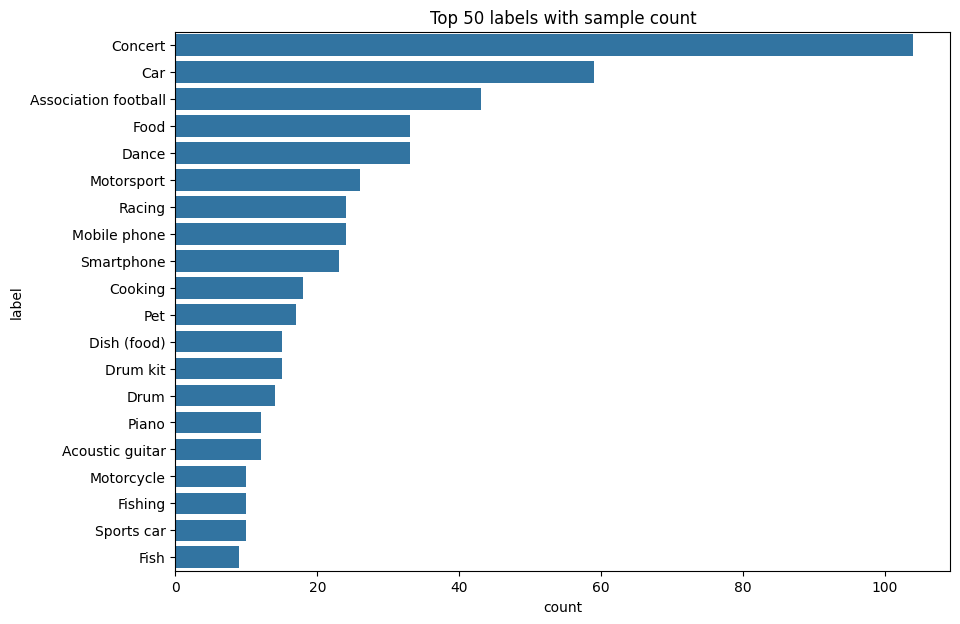

In [106]:
# Visualization of the frequencie's labels

labels_count_dict = dict(top_n)
labels_count_df = pd.DataFrame.from_dict(labels_count_dict, orient='index').reset_index()
labels_count_df.columns = ['label', 'count']
labels_count_df['label'] = labels_count_df['label'].map(label_mapping, na_action='ignore')
TOP_labels = list(labels_count_df['label'])[:n]
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y='label', x='count', data=labels_count_df)
plt.title('Top {} labels with sample count'.format(n))

In [107]:
unique_vert1_count = vocab_df['Vertical1'].nunique()
print(f"Unique Vertical1 Values: {unique_vert1_count}")

Unique Vertical1 Values: 24
